In [58]:
## Load Imports

from opacus_new import PrivacyEngine
from opacus_new.accountants import RDPAccountant
from opacus_new.validators.module_validator import ModuleValidator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as models

import numpy as np
import seaborn as sns

from types import SimpleNamespace
from tqdm import tqdm
import pandas as pd
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [59]:
## Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, num_samples=10_000, height=32, width=32, num_features=3, transform=None, target_transform=None):
        self.data = (255 * np.random.rand(num_samples, height, width, num_features)).astype(np.uint8)
        self.targets = torch.randint(0, 10, (num_samples,))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Apply transformations if any
        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
            target = self.target_transform(target)

        return sample, target
    
    @classmethod
    def from_dataset(cls, dataset):
        return cls(data=dataset.data,
                targets=dataset.targets,
                transform=dataset.transform,
                target_transform=dataset.target_transform)

In [60]:
## Define a custom model class

class DummyResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [61]:
def make_private(model, train_loader, pp_budgets, args):
    modulevalidator = ModuleValidator()
    model = modulevalidator.fix_and_validate(model)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    privacy_engine = PrivacyEngine(accountant=args.accountant,
                                   individualize=args.individualize,
                                   weights=args.weights,
                                   pp_budgets=pp_budgets)
    if args.adapt_weights_to_budgets:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private_with_epsilon(module=model,
                                       optimizer=optimizer,
                                       data_loader=train_loader,
                                       target_epsilon=min(pp_budgets),
                                       target_delta=args.target_delta,
                                       epochs=args.epochs,
                                       max_grad_norm=args.max_grad_norm,
                                       optimal=True,
                                       max_alpha=10_000)
                                    #    numeric=True)
    else:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private(module=model,
                          optimizer=optimizer,
                          data_loader=train_loader,
                          noise_multiplier=args.noise_multiplier,
                          max_grad_norm=args.max_grad_norm)

    if args.individualize == 'clipping':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": privacy_engine.weights,
            "sample_rate": [1 / len(private_loader)] * len(privacy_engine.weights),
            "noise_multiplier": [private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    elif args.individualize == 'sampling':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": [args.max_grad_norm] * len(privacy_engine.weights),
            "sample_rate":privacy_engine.weights,
            "noise_multiplier":[private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    else:
        return

In [62]:
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    def compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm):
        accountant = RDPAccountant()
        for _ in range(int(iterations)):
            accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
        return accountant.get_epsilon(delta)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = compute_epsilon(noise_multiplier, delta, iterations, sampling_rate, clipping_norm)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

In [63]:
args = SimpleNamespace(
    accountant="rdp",  # Options: "rdp", "gdp", etc.
    individualize="sampling", # "sampling",  # Options: None, "clipping", "sampling"
    weights=None,  # Should be a list or None
    adapt_weights_to_budgets=True,  # Whether to adapt weights to budgets
    target_delta=1e-5,  # Default delta value for DP
    epochs=5,  # Number of training epochs
    max_grad_norm=1,  # Clipping norm for DP-SGD
    # noise_multiplier=1.0,  # Noise multiplier for DP
    n_data=2000,  # Number of data points
)
dummy_train_loader = DataLoader(CustomDataset(num_samples=args.n_data), batch_size=128, shuffle=True)
dummy_model = DummyResNet18()


overwrite = True
deltas = np.logspace(-9, -1, num=50)
privacy_groups = [[1, 8], [2, 8], [4, 8]] # np.linspace(3, 20, num=5)
portion_size_var = [0.05, 0.2, 0.5, 0.8, 0.95]

In [64]:
def list_to_string(lst, sep=","):
    """Converts a list of values to a string with a given separator."""
    return sep.join(map(str, lst))

def string_to_list(s, sep=",", dtype=float):
    """Converts a string back to a list of values of the specified dtype."""
    return [dtype(item) for item in s.split(sep) if item]

In [65]:
import concurrent.futures

def compute_for_portion(args_tuple):
    privacy_group, portion = args_tuple
    priv_g = privacy_group[0]
    priv_ig = privacy_group[1]
    pp_budgets = [priv_g] * int(portion * args.n_data) + [priv_ig] * int(args.n_data - int(portion * args.n_data))
    sampling_data = make_private(dummy_model, dummy_train_loader, pp_budgets, args)
    sampling_data_noise_multiplier = sampling_data['noise_multiplier']
    sampling_data_max_grad_norms = sampling_data['max_grad_norms']
    sampling_data_sample_rate = sampling_data['sample_rate']

    epsilons_g, deltas_out_g = compute_epsilon_delta(
        noise_multiplier=sampling_data_noise_multiplier[0],
        deltas=deltas,
        iterations=args.epochs * len(dummy_train_loader),
        sampling_rate=sampling_data_sample_rate[0],
        clipping_norm=sampling_data_max_grad_norms[0]
    )

    epsilons_ig, deltas_outi_g = compute_epsilon_delta(
        noise_multiplier=sampling_data_noise_multiplier[1],
        deltas=deltas,
        iterations=args.epochs * len(dummy_train_loader),
        sampling_rate=sampling_data_sample_rate[1],
        clipping_norm=sampling_data_max_grad_norms[1]
    )
    return portion, {
        "portion_g": portion,
        "portion_ig": 1 - portion,
        "epsilons_g": epsilons_g,
        "deltas_out_g": deltas_out_g,
        "epsilons_ig": epsilons_ig,
        "deltas_outi_g": deltas_outi_g,
        "sampling_data_sample_rate": sampling_data_sample_rate,
        "sampling_data_max_grad_norms": sampling_data_max_grad_norms,
        "sampling_data_noise_multiplier": sampling_data_noise_multiplier
    }

results = {}
for privacy_group in privacy_groups:
    results_group = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        args_list = [(privacy_group, portion) for portion in portion_size_var]
        for portion, res in tqdm(executor.map(compute_for_portion, args_list), total=len(portion_size_var)):
            results_group[portion] = res
    results[list_to_string(privacy_group)] = results_group

100%|██████████| 5/5 [02:46<00:00, 33.32s/it] 


/tmp/ipykernel_3792949/132657867.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orange_cmap = mpl.cm.get_cmap('Oranges')
/tmp/ipykernel_3792949/132657867.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_cmap = mpl.cm.get_cmap('Blues')


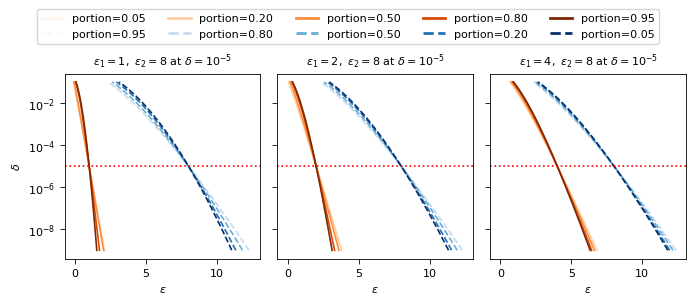

In [69]:
import matplotlib as mpl
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

mpl.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'lines.linewidth': 1.2,
    'axes.linewidth': 0.6,
    'xtick.major.width': 0.6,
    'ytick.major.width': 0.6,
    'xtick.minor.width': 0.4,
    'ytick.minor.width': 0.4,
})

# Prepare color maps for saturation
orange_cmap = mpl.cm.get_cmap('Oranges')
blue_cmap = mpl.cm.get_cmap('Blues')

orange_cmap = [orange_cmap(x) for x in np.linspace(0, 1, len(portion_size_var))]
blue_cmap = [blue_cmap(x) for x in np.linspace(0, 1, len(portion_size_var))]

fig_width = 7 # 5.5  # target width in inches
ncols = len(privacy_groups)
fig_height = 2.8  # adjust height to balance aspect ratio

fig, axes = plt.subplots(1, ncols, figsize=(fig_width, fig_height), sharey=True, sharex=True)
if len(privacy_groups) == 1:
    axes = [axes]


for j, (ax, privacy_group) in enumerate(zip(axes, privacy_groups)):
    group_key = list_to_string(privacy_group)
    results_group = results[group_key]
    for i, portion in enumerate(portion_size_var):
        color_g = orange_cmap[i]
        color_ig = blue_cmap[i]
        label = f"portion_g={portion:.2f}"
        # Plot epsilons_g
        ax.plot(results_group[portion]["epsilons_g"], results_group[portion]["deltas_out_g"],
                color=color_g, label=label if i == 0 else None, linewidth=1.2)
        # Plot epsilons_ig
        ax.plot(results_group[portion]["epsilons_ig"], results_group[portion]["deltas_outi_g"],
                color=color_ig, label=None, linestyle='--', linewidth=1.2)
    ax.axhline(args.target_delta, color='red', linestyle=':', label='target_delta')
    ax.set_yscale('log')
    if j == 0:
        ax.set_ylabel(rf'$\delta$')
    ax.set_xlabel(rf'$\varepsilon$')
    ax.set_title(
    rf'$\varepsilon_1 = {privacy_group[0]}, \ \varepsilon_2 = {privacy_group[1]}$ at $\delta=10^{{-5}}$'
)
    # ax.grid(True)

# Custom legend for portions
legend_elements = []
for i, portion in enumerate(portion_size_var):
    color_g = orange_cmap[i]
    color_ig = blue_cmap[i]
    legend_elements.append(Line2D([0], [0], color=color_g, lw=2, label=f'portion={portion:.2f}'))
    legend_elements.append(Line2D([0], [0], color=color_ig, lw=2, linestyle='--', label=f'portion={1-portion:.2f}'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=legend_elements, loc='upper center', ncol=len(portion_size_var), bbox_to_anchor=(0.5, 1.08))
fig.savefig("privacy_tradeoff_plot.svg", format="svg", bbox_inches='tight')
fig.savefig("privacy_tradeoff_plot.png", format="png", dpi=300, bbox_inches='tight')
plt.show()